# Practical 1
## Task description
In this practical, you will implement linear regression using the least squares method. For the first part, the task is to implement the linear model from scratch using the numpy package. You will need to use learning curves plot to understand whether the linear model is overfitting or underfitting. For the more advanced part, the task is to implement linear models with polynomial basis expansions and regularizations (Ridge and Lasso) by making use of a package called scikit-learn. The optional task is to use k-fold cross validation to obtain the optimal hyper-parameters for the models. You can get 5 bonus points for doing the optional task. The practical will use the winequality dataset, which is available here: https://archive.ics.uci.edu/ml/datasets/Wine+Quality

## Import the libraries

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import io
from numpy.linalg import inv
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold, cross_val_score, train_test_split, LeaveOneOut, ShuffleSplit

## Import the Data Sets from Github

In [65]:
#Download all red wines
url_red = "https://raw.githubusercontent.com/TR537/Foundations-of-Data-Science/main/winequality-red.csv"
download_red = requests.get(url_red).content
df_red = pd.read_csv(io.StringIO(download_red.decode('utf-8')),sep=';')

df_red

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [66]:
#Download all white wines
url_white = "https://raw.githubusercontent.com/TR537/Foundations-of-Data-Science/main/winequality-white.csv"
download_white = requests.get(url_white).content
df_white = pd.read_csv(io.StringIO(download_white.decode('utf-8')),sep=';')

df_white

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [155]:
#Merge the data sets into one dataframe for analysis
df = df_red.append(df_white, ignore_index=True, verify_integrity=False, sort=False)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


# OLS Linear Regression

In [170]:
#Define inputs as a matrix X
df_inputs_lin = df.copy()
X_lin = df_inputs_lin.drop('quality', axis=1)

#Add a column of ones to X for the intercept
X_lin = np.c_[np.ones(len(X_lin.alcohol)), X_lin]

#Control the inputs
X_lin

array([[ 1.  ,  7.4 ,  0.7 , ...,  3.51,  0.56,  9.4 ],
       [ 1.  ,  7.8 ,  0.88, ...,  3.2 ,  0.68,  9.8 ],
       [ 1.  ,  7.8 ,  0.76, ...,  3.26,  0.65,  9.8 ],
       ...,
       [ 1.  ,  6.5 ,  0.24, ...,  2.99,  0.46,  9.4 ],
       [ 1.  ,  5.5 ,  0.29, ...,  3.34,  0.38, 12.8 ],
       [ 1.  ,  6.  ,  0.21, ...,  3.26,  0.32, 11.8 ]])

In [171]:
#Define the output variable as a vector y
y_lin = df.quality.values

#Control the outputs
y_lin

array([5, 5, 5, ..., 6, 7, 6])

In [172]:
#Compute the regression coefficients using linear algebra
beta_OLS = inv(X_lin.T @ X_lin) @ X_lin.T @ y_lin
print(beta_OLS)

[ 5.57627495e+01  6.76839155e-02 -1.32789221e+00 -1.09656648e-01
  4.35587507e-02 -4.83713531e-01  5.96988830e-03 -2.48129841e-03
 -5.49669421e+01  4.39296071e-01  7.68251760e-01  2.67030009e-01]


# Ridge Regression

In [173]:
#Define inputs as a matrix X
df_inputs_rid = df.copy()
X_rid = df_inputs_rid.drop('quality', axis=1)

#Control the inputs
X_rid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
dtypes: float64(11)
memory usage: 558.5 KB


In [175]:
#Define the outputs as a vector y
y_rid = df.quality.values

n = len(df)

#Control the outputs
y_rid

array([5, 5, 5, ..., 6, 7, 6])

In [196]:
# Initialize alpha grid
n_grid = 100
alphas = 10**np.linspace(-1,8,n_grid).reshape(-1,1)
ridge = Ridge()
ridge_coefs = []

# Loop over values of alpha
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    ridge_coefs.append(ridge.coef_)
ridge_coefs = np.reshape(ridge_coefs,(n_grid,-1))

In [197]:
# OLS regression
mod_ols = np.linalg.norm(beta_OLS)

# Relative magnitude of ridge coefficients in comparison to OLS coefficients
rel_beta = [np.linalg.norm(ridge_coefs[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

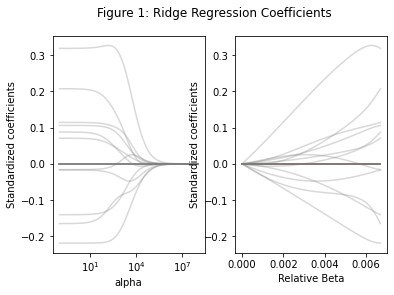

In [198]:
# Figure 1
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('Figure 1: Ridge Regression Coefficients')

#highlight = [0,1,2,7];

# Plot coefficients - absolute
#ax1.plot(alphas, ridge_coefs[:,highlight], alpha=1)
ax1.plot(alphas, ridge_coefs, c='grey', alpha=0.3)
ax1.set_xscale('log')
ax1.set_xlabel('alpha'); ax1.set_ylabel('Standardized coefficients');

# Plot coefficients - relative
ax2.plot(rel_beta, ridge_coefs[:,highlight], alpha=1)
ax2.plot(rel_beta, ridge_coefs, c='grey', alpha=0.3)
ax2.set_xlabel('Relative Beta'); ax2.set_ylabel('Standardized coefficients');

# Lasso regression

In [179]:
#Define inputs as a matrix X
df_inputs_las = df.copy()
X_las = df_inputs_las.drop('quality', axis=1)

#Control the inputs
X_las.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
dtypes: float64(11)
memory usage: 558.5 KB


In [186]:
#Define outputs as a vector y
y_las = df.quality.values

n = len(df)

#Control the outputs
y_las

array([5, 5, 5, ..., 6, 7, 6])

In [193]:
# Initialize alpha grid
n_grid = 100
alphas = 10**np.linspace(-4,2,n_grid).reshape(-1,1)
lasso = Lasso()
lasso_coefs = []

# Loop over values of alpha
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X), y)
    lasso_coefs.append(lasso.coef_)
lasso_coefs = np.reshape(lasso_coefs,(n_grid,-1))

In [194]:
# Relative magnitude
mod_ols = np.linalg.norm(beta_OLS)
rel_beta = [np.linalg.norm(lasso_coefs[i,:])/mod_ols for i in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

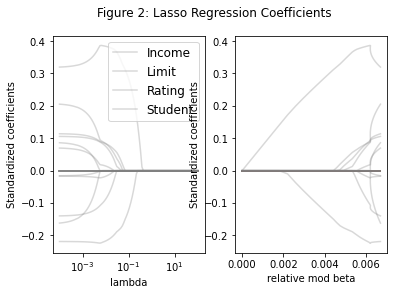

In [195]:
# Figure 2
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('Figure 2: Lasso Regression Coefficients')

# highlight = [0,1,2,7];

# Plot coefficients - absolute
# ax1.plot(alphas, lasso_coefs[:,highlight], alpha=1)
ax1.plot(alphas, lasso_coefs, c='grey', alpha=0.3)
ax1.set_xscale('log')
ax1.set_xlabel('lambda'); ax1.set_ylabel('Standardized coefficients');
ax1.legend(['Income', 'Limit', 'Rating', 'Student'], fontsize=12)

# Plot coefficients - relative
ax2.plot(rel_beta, lasso_coefs[:,highlight], alpha=1)
ax2.plot(rel_beta, lasso_coefs, c='grey', alpha=0.3)
ax2.set_xlabel('relative mod beta'); ax2.set_ylabel('Standardized coefficients');

# K-fold cross validation for parameter selection

## Ridge

In [199]:
#Define inputs as a matrix X
df_inputs_cross = df.copy()
X_cross = df_inputs_cross.drop('quality', inplace=True, axis=1)

#Define outputs as a vector y
y_cross = df.quality

n = len(df)

In [200]:
# Get the Mean Squared Error
def cv_lasso(X,y,a,k):
    
    # Initialize mse
    mse = []
    
    # Generate splits
    crossk = KFold(n_splits=k, random_state=None, shuffle=False)
    crossk.get_n_splits(X)
    
    # Loop over splits
    for train_index, test_index in crossk.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lasso = Lasso(alpha=a).fit(X_train, y_train)
        y_hat = lasso.predict(X_test)
        mse.append(mean_squared_error(y_test, y_hat))
    return np.mean(mse)

In [201]:
# Compute MSE over grid of alphas
n_grid = 30
alphas = 10**np.linspace(0,3,n_grid).reshape(-1,1)
MSE = [cv_lasso(X_cross,y_cross,a,10) for a in alphas]

TypeError: Expected sequence or array-like, got <class 'NoneType'>